In [1]:
from scipy.optimize import minimize
from scipy.integrate import odeint
import mystic
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# Anzahl der Zeitschritte
N = 100
h = 3
# Anfangswerte der Steuerung
u_0 = np.zeros(N)
u_0 = np.append(u_0,[1])
# print(u_0)

#Anfangswert der Zustände
y0 = np.array([0,0.6])
# print(y0)

# Parameter für das Funktional
cu = 1/10
cx = 20000
cz = 1/100

# Endwerte der Zustände
xT = 0.1
zT = 200

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
[ 0.   0.6]


In [3]:
# Zustandsgleichungen
# Parameter des Modells
a = 0.2;
a1 = -0.0052;
b1 = -0.0656;
c1 = 0.147;
a3 = 0.0071;
b3 = 0.0539;
c3 = -0.71;
s = 1.21;
t = 0.126;

# Reynoldzahl
Re = 10;


In [4]:
def Zustandsgleichung(x,u,flag):

    # Hilsfunktionen
    phi1 =  a1*np.power(u,2)+b1*u+c1
    phi3 = a3*np.power(u,2)+b3*u+c3
    phiw = np.power(10,-8)
    fw = np.divide(1,np.power(x-1.001*(1-a),3)) +  np.divide(1,np.power(x+1.001*(1-a),3))
    Dfw = np.divide(-3,np.power(x-1.001*(1-a),4)) - np.divide(3,np.power(x+1.001*(1-a),4))
    ksi = 3*np.pi*Re*a *(s+t*(np.divide(a,1.001-a-np.absolute(x))))
    
    f1 = -np.power(x,2) + 1 + np.divide(1,ksi)*u;
    f2 = np.divide(1,ksi)*(phi1*x + phi3*(np.power(x,3)) + phiw*fw);
    # Gibt die rechte Seite zurück
    if flag == 'f':
        return np.array([f1,f2])
    # Gibt die Ableitung nach x zurück
    elif flag == 'Df':
        ksix = np.divide(-a*t,np.power(a*t-s*(a+x-1),2));
        DDx1 = -2*x + ksix *u;
        Dx2 = np.divide(1,ksi)*(phi1*x + phi3*np.power(x,3) + phiw*fw);
        DDx2 = np.divide(1,ksi)*(phi1 + 3 *phi3*np.power(x,2) + phiw*Dfw)+ksix * f2;
        return np.array([DDx1,DDx2])
    else:
        return 'Error'

#print(Zustandsgleichung(x,u,1))

In [5]:
# Lösen der Zustandsgleichung mit expliziten Euler

def Euler(u):
    y = np.zeros((2,N+1))
    y[:,0] = y0
    for i in range(1,N+1):
        f = Zustandsgleichung(y[1,i-1],u[i-1],'f')
        y[:,i] = y[:,i-1] + u[N]* f
    return y
    

In [8]:
#Zielfunktional 

def Funktional(u):
    zx = Euler(u)
    J = cx*np.power(zx[1,-1]-xT,2) +cu*u[N]*(np.dot(u[0:N],u[0:N]))+cz*np.power(zx[0,-1]- zT,2)
    return J

In [22]:
# Minimiere das Zielfunktional
# method='CG' oder method = 'L-BFGS-B'
Min = minimize(Funktional, u_0, method='L-BFGS-B',options={'disp': True})

# Berechne den zugehörigen Zustand
ymin = Euler(Min.x)


219.534529024
Schrittweite:2.2450647135


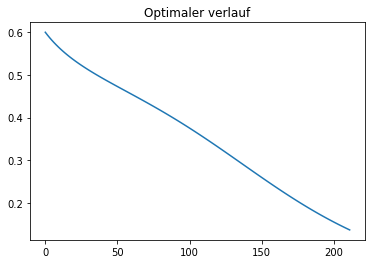

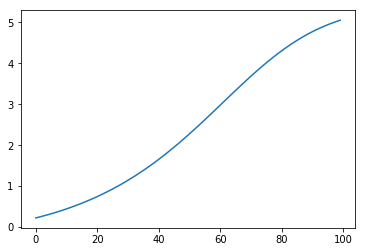

In [23]:
# Plotten der Ergebnisse
print(Funktional(Min.x))
plt.figure()
plt.title('Optimaler verlauf')
plt.plot(ymin[0,:],ymin[1,:])
plt.figure()
plt.plot(Min.x[0:N])
print('Schrittweite:'+ str(Min.x[N]))

In [11]:
# Überprüfen mit Pontrjaginschen Maximumprinzip

# Adjungierte berechnen
p = np.zeros((2,N+1))
print(p.shape)
p[:,N] = np.array([2*cz*(ymin[0,-1]-zT),2*cx*(ymin[1,-1]-xT)])
u = Min.x
print(u.shape)
for i in range(1,N+1):
        #print(i)
        Df = Zustandsgleichung(ymin[1,N-i],u[N-i],'Df')
        #print(u[N])
        p[:,N-i] = p[:,N-i+1] + u[N]* Df

f = Zustandsgleichung(ymin[1,0:N],u[0:N],'f')
# Hamilton Funktion
H_p = cz*np.power(ymin[0,-1]-zT,2) + cx*np.power(ymin[1,-1]-xT,2) #+cu*u[0:N]*u[0:N] + p[0,1:N+1]*f[0,:]+ p[1,1:N+1]*f[1,:]
print(H_p)

(2, 101)
(101,)
2.14143866153
